<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Summary" data-toc-modified-id="Summary-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Summary</a></span><ul class="toc-item"><li><span><a href="#Log" data-toc-modified-id="Log-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Log</a></span></li><li><span><a href="#To-do" data-toc-modified-id="To-do-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>To do</a></span></li></ul></li><li><span><a href="#Data" data-toc-modified-id="Data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data</a></span><ul class="toc-item"><li><span><a href="#Create-dls" data-toc-modified-id="Create-dls-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Create dls</a></span></li></ul></li><li><span><a href="#Basic-SSD" data-toc-modified-id="Basic-SSD-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Basic SSD</a></span><ul class="toc-item"><li><span><a href="#Architecture" data-toc-modified-id="Architecture-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Architecture</a></span></li><li><span><a href="#Loss" data-toc-modified-id="Loss-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Loss</a></span><ul class="toc-item"><li><span><a href="#Create-Anchors" data-toc-modified-id="Create-Anchors-3.2.1"><span class="toc-item-num">3.2.1&nbsp;&nbsp;</span>Create Anchors</a></span></li><li><span><a href="#BBox-and-Lbl-Loss" data-toc-modified-id="BBox-and-Lbl-Loss-3.2.2"><span class="toc-item-num">3.2.2&nbsp;&nbsp;</span>BBox and Lbl Loss</a></span></li><li><span><a href="#Intersection-Over-Union-(IOU)" data-toc-modified-id="Intersection-Over-Union-(IOU)-3.2.3"><span class="toc-item-num">3.2.3&nbsp;&nbsp;</span>Intersection Over Union (IOU)</a></span></li><li><span><a href="#Putting-it-all-together-(ssd_loss)" data-toc-modified-id="Putting-it-all-together-(ssd_loss)-3.2.4"><span class="toc-item-num">3.2.4&nbsp;&nbsp;</span>Putting it all together (ssd_loss)</a></span></li></ul></li><li><span><a href="#Viewing-data-&amp;-results" data-toc-modified-id="Viewing-data-&amp;-results-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Viewing data &amp; results</a></span></li><li><span><a href="#Training" data-toc-modified-id="Training-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Training</a></span></li><li><span><a href="#Results-for-basic-SSD" data-toc-modified-id="Results-for-basic-SSD-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Results for basic SSD</a></span></li></ul></li><li><span><a href="#More-Boxes!" data-toc-modified-id="More-Boxes!-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>More Boxes!</a></span><ul class="toc-item"><li><span><a href="#New-code" data-toc-modified-id="New-code-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>New code</a></span></li><li><span><a href="#Training" data-toc-modified-id="Training-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Training</a></span></li><li><span><a href="#Results-for-more-boxes" data-toc-modified-id="Results-for-more-boxes-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Results for more boxes</a></span></li></ul></li><li><span><a href="#Focal-Loss" data-toc-modified-id="Focal-Loss-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Focal Loss</a></span><ul class="toc-item"><li><span><a href="#New-code" data-toc-modified-id="New-code-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>New code</a></span></li><li><span><a href="#Training" data-toc-modified-id="Training-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Training</a></span></li><li><span><a href="#Results-for-focal-loss" data-toc-modified-id="Results-for-focal-loss-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>Results for focal loss</a></span></li></ul></li></ul></div>

# Summary

Diving deep into DL4C 2018 lesson 9 to implement SSD object detection ([link to the video here](https://www.youtube.com/watch?v=0frKXR-2PBY)).

## Log

- 2020-10-27 (Tues): Started implementing Jeremy's solution w/ anchor boxes in 2018.9. Made progress. Left off video at 57:49.
- 2020-11-05 (Thurs): Discovered bug in reading from pickled dataframe that was causing multilabel tensors to be created as float dtype instead of int dtype.
- 2020-11-06 (Fri): It's working! I got it working last night, but today I looked at the results, and they totally make sense! Still a few things to do, but this is a great result.

## To do

- show results in only one line of code
- save learners for faster code exploration

# Data

## Create dls

In [ ]:
from fastai.vision.all import *


### Params ###
im_size    = 224
batch_size = 64
valid_pct  = .10
subset_pct = .3

# paths
path = Path('/home/rory/data/coco2017')
train_im_dir, valid_im_dir = 'train2017', 'val2017'
train_json = 'annotations/instances_train2017.json'
valid_json = 'annotations/instances_val2017.json'


### Get Items ###
def get_annos(path, anno_file, im_folder):
    xs, ys = get_annotations(path/anno_file)
    return L(xs).map(lambda x: path/im_folder/x), ys
train_paths, train_annos = get_annos(path, train_json, train_im_dir)
valid_paths, valid_annos = get_annos(path, valid_json, valid_im_dir)
paths = train_paths + valid_paths
annos = train_annos + valid_annos
p2a = {p:b for p,b in zip(paths,annos)}
def get_bbox(p): return p2a[p][0]
def get_lbl(p):  return p2a[p][1]


### DataBlock & DataLoaders ###
db = DataBlock(
    blocks=[ImageBlock, BBoxBlock, BBoxLblBlock],
    get_y=[get_bbox, get_lbl],
    splitter=RandomSplitter(valid_pct),
    item_tfms=Resize(im_size, method='squish'),
    batch_tfms=Normalize.from_stats(*imagenet_stats),
    n_inp=1)
subset = paths.shuffle()[0:int(len(paths)*subset_pct)]
dls = db.dataloaders(subset)


### Inspection (IMPORTANT) ###
print("Size of train data:",len(dls.train.items))
print("Size of valid data:",len(dls.valid.items))
for i,t in enumerate(dls.one_batch()):
    print(f"batch[{i}]:",'\t',t.dtype,'\t',t.shape)

Size of train data: 32999
Size of valid data: 3666
batch[0]: 	 torch.float32 	 torch.Size([64, 3, 224, 224])
batch[1]: 	 torch.float32 	 torch.Size([64, 30, 4])
batch[2]: 	 torch.int64 	 torch.Size([64, 30])


# Basic SSD

## Architecture

In [ ]:
# StdConv (used in SSD_Head) wraps together the standard conv2d → batchnorm → dropout.
class StdConv(Module):
    # 42:00
    def __init__(self, nin, nout, stride=2, drop=0.1):
        super().__init__()
        self.conv = nn.Conv2d(nin, nout, 3, stride=stride, padding=1)
        self.bn = nn.BatchNorm2d(nout)
        self.drop = nn.Dropout(drop)
        
    def forward(self, x): return self.drop(self.bn(F.relu(self.conv(x))))

# OutConv (used in SSD_Head) creates two output layers (one for bboxes, one for lbls).
class OutConv(Module):
    # output is two conv layers (instead of one linear layer)
    def __init__(self, k, nin, bias):
        super().__init__()
        self.k = k
        self.oconv1 = nn.Conv2d(nin, 4*k, 3, padding=1)              # bbs
        self.oconv2 = nn.Conv2d(nin, len(dls.vocab)*k, 3, padding=1) # lbls
        self.oconv2.bias.data.zero_().add_(bias)
        
    def forward(self, x):
        return [self._flatten_conv(self.oconv1(x), self.k),
                self._flatten_conv(self.oconv2(x), self.k)]
    
    def _flatten_conv(self,x,k):
        return x.view(x.size(0), x.size(1)//k, -1).transpose(1,2)

# Uses the above two modules to create the custom multi-layer output head.
class SSD_Head(Module):
    def __init__(self, k, bias):
        super().__init__()
        self.drop = nn.Dropout(0.25)
        self.sconv0 = StdConv(512,256, stride=1)
        self.sconv1 = StdConv(256,256)
        self.out = OutConv(k, 256, bias)
        
    def forward(self, x):
        x = self.drop(F.relu(x))
        x = self.sconv0(x)
        x = self.sconv1(x)
        return self.out(x)

# Simple class for joining a body and a head.
class Custom_Module(Module):
    def __init__(self, body, head):
        self.body, self.head = body, head
        
    def forward(self, x):
        return self.head(self.body(x))

## Loss

### Create Anchors

In [ ]:
def create_anchors(k=1, subdivs=4, device='cuda'):
    box_size = 1/subdivs
    anc_offset = box_size*.5
    anc_x = np.repeat(np.linspace(anc_offset, 1-anc_offset, subdivs), subdivs)
    anc_y = np.tile(  np.linspace(anc_offset, 1-anc_offset, subdivs), subdivs)
    anc_ctrs = np.tile(np.stack([anc_x,anc_y], axis=1), (k,1))
    anc_hws = np.array([[box_size,box_size] for i in range(subdivs**2)])
    anchors = torch.cat((tensor(anc_ctrs), tensor(anc_hws)), axis=1)
    box_size = tensor(np.array([box_size]), requires_grad=False).unsqueeze(1)
    return anchors.to(device), box_size.to(device)

def create_anchor_boxes(ctr, hw):
    return 2*torch.cat((tensor(ctr-hw/2), tensor(ctr+hw/2)), axis=1)-1

### BBox and Lbl Loss

In [ ]:
# embed classes for use in BCE_Loss
def one_hot_embedding(lbls, n_cls):
    # can I replace this with fastai's one hot fxn?
    return torch.eye(n_cls)[lbls.data.long()]

# lbl_loss will use binary cross entropy
class BCE_Loss(nn.Module):
    # 1:05:35
    def __init__(self, n_cls):
        super().__init__()
        self.n_cls = n_cls
        
    def forward(self, act_lbl, targ_lbl):
        a = act_lbl[:,1:]
        t = one_hot_embedding(targ_lbl, self.n_cls)
        t = tensor(t[:,1:].contiguous()).type_as(a) # can I remove type_as?
        w = self.get_weight(a,t)
        return F.binary_cross_entropy_with_logits(a,t,None,reduction='sum')/self.n_cls
    
    def get_weight(self,a,t): return None
    
# bb_loss will use mean absolute error
def mae(t1, t2):
    return ((t1 - t2).abs()).mean()

### Intersection Over Union (IOU)

In [ ]:
def intersxn(b1,b2):
    x1 = torch.max((b1)[:,None,0], (b2)[None,:,0])
    y1 = torch.max((b1)[:,None,1], (b2)[None,:,1])
    x2 = torch.min((b1)[:,None,2], (b2)[None,:,2])
    y2 = torch.min((b1)[:,None,3], (b2)[None,:,3])
    return torch.clamp((x2-x1), min=0) * torch.clamp((y2-y1), min=0)

def area(b):
    return (b[:,2]-b[:,0]) * (b[:,3]-b[:,1])

def get_iou(b1, b2):
    inter = intersxn(b1,b2)
    union = area(b1).unsqueeze(1) + area(b2).unsqueeze(0) - inter
    return inter / union

### Putting it all together (ssd_loss)

In [ ]:
def remove_padding(bb, lbl):
    # 1:11:10
    bb = bb.view(-1,4)
    padding = (bb[:,2]-bb[:,0])==0
    return bb[~padding],lbl[~padding]

def adjust_anchor_boxes(act_bb, anchors, box_size):
    acts = torch.tanh(act_bb) # scale acts 
    ctrs = anchors[:,:2] + (acts[:,:2]/2 * box_size) # move ctrs by up to box_size/2
    hws  = anchors[:,2:] * (acts[:,2:]/2+1)
    return create_anchor_boxes(ctrs, hws)

def get_targ_idx(ious):
    max_iou_per_bb, anc_idxs = ious.max(1)
    max_iou_per_anc, bb_idxs = ious.max(0)
    max_iou_per_anc[anc_idxs] = 1.99
    for i,iou in enumerate(anc_idxs): bb_idxs[iou] = i
    return max_iou_per_anc, bb_idxs

def ssd_item_loss(act_bb, act_lbl, bb, lbl):
    # 1:11:30
    bb, lbl = remove_padding(bb, lbl)
    pred_bb = adjust_anchor_boxes(act_bb, anchors, box_size)
    ious = get_iou(bb.data, anchor_boxes.data)
    anc_ious, targ_idx = get_targ_idx(ious)
    targ_lbl = lbl[targ_idx]
    above_thresh = anc_ious > 0.4
    assigned_idx = torch.nonzero(above_thresh)[:,0]
    targ_lbl[~above_thresh] = 0
    targ_bb = bb[targ_idx]
    # assign fxns to bb_loss and lbl_loss
    bb_loss_res = bb_loss(pred_bb[assigned_idx], targ_bb[assigned_idx])
    lbl_loss_res = lbl_loss(act_lbl, targ_lbl)
    return bb_loss_res, lbl_loss_res

def ssd_loss(acts, bbs, lbls):
    sum_bb_loss, sum_lbl_loss = 0., 0.
    for act_bb,act_lbl,bb,lbl in zip(*acts, bbs, lbls):
        bb_loss,lbl_loss = ssd_item_loss(act_bb,act_lbl,bb,lbl)
        sum_bb_loss += bb_loss
        sum_lbl_loss += lbl_loss
    return sum_bb_loss + sum_lbl_loss

## Viewing data & results

In [ ]:
def show_bb(im, bb, lbl, sz=224,figsize=[5,5],color='white',ctx=None,title=None):
    # process tensors to take advantage of fastai show methods
    bbox = TensorBBox((bb+1)*sz//2)
    labeledbbox = LabeledBBox(bbox,lbl)
    
    if ctx: show_image(im, figsize=figsize, title=title, ctx=ctx)
    else:   ctx = show_image(im, figsize=figsize, title=title)
    
    labeledbbox.show(ctx=ctx)       # first, draw white lbl bbs...
    bbox.show(ctx=ctx, color=color) # ... then overlay color bbs.
    return ctx

In [ ]:
def nms(boxes, scores, overlap=0.5, top_k=100):
    keep = scores.new(scores.size(0)).zero_().long()
    if boxes.numel() == 0: return keep
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]
    area = torch.mul(x2-x1, y2-y1)
    v, idx = scores.sort(0) # sort asc
    idx = idx[-top_k:] # idxs of the top-k lrgst vals
    xx1 = boxes.new()
    yy1 = boxes.new()
    xx2 = boxes.new()
    yy2 = boxes.new()
    w = boxes.new()
    h = boxes.new()
    
    count = 0
    while idx.numel() > 0:
        i = idx[-1] # idx of current lrgst val
        keep[count] = i
        count+=1
        if idx.size(0) == 1: break
        idx = idx[:-1] # remove kept element from view
        # load bboxes
        torch.index_select(x1, 0, idx, out=xx1)
        torch.index_select(y1, 0, idx, out=yy1)
        torch.index_select(x2, 0, idx, out=xx2)
        torch.index_select(y2, 0, idx, out=yy2)
        # store element-wise max with next highest score
        xx1 = torch.clamp(xx1, min=x1[i])
        yy1 = torch.clamp(yy1, min=y1[i])
        xx2 = torch.clamp(xx2, min=x2[i])
        yy2 = torch.clamp(yy2, min=y2[i])
        w.resize_as_(xx2)
        h.resize_as_(yy2)
        w = xx2 - xx1
        h = yy2 - yy1
        # check sizes of xx1 and xx2... after each iter
        w = torch.clamp(w, min=0.0)
        h = torch.clamp(h, min=0.0)
        inter = w*h
        # IoU
        rem_areas = torch.index_select(area, 0, idx)
        union = (rem_areas - inter) + area[i]
        iou = inter/union
        idx = idx[iou.le(overlap)]
    return keep, count

In [ ]:
zooms, ratios

([0.75, 1.0, 1.3], [(1.0, 1.0), (1.0, 0.5), (0.5, 1)])

In [ ]:
create_anchors??

In [ ]:
ancs, box_sz = 

In [ ]:
class ResultShower():
    def __init__(self, dls, lrn, ancs, anc_sz):
        self.dls,  self.mod    = dls,  lrn.model
        self.ancs, self.anc_sz = ancs, anc_sz
        self.batch = self.dls.cpu().one_batch()
        self.acts  = self.mod.cpu()(self.batch[0])
        self.acts  = [a.data for a in self.acts]
        self.last_res = 0
        
    def __call__(self, n, fig_sz=8):
        return self._show_results(n, fig_sz)
        
    def _show_results(self, n, figsz=8):
        b_ims,b_bbs,b_lbls = self.batch
        act_bbs,act_lbls = self.acts
    
        for i in range(n):
            idx=self.last_res+i

            # grab im, targ, acts
            im = self.dls.decode(self.batch)[0][idx]
            bb  = b_bbs[idx]
            lbl = b_lbls[idx]
            act_bb  = act_bbs[idx]
            act_lbl = act_lbls[idx]

            # convert acts to preds
            pred_bb = adjust_anchor_boxes(act_bb,self.ancs,self.anc_sz)
            pred_lbl = act_lbl.max(1)[1]
            lbl_conf = act_lbl.max(1)[0].sigmoid().data

            # nms
            nms_idxs, nms_n = nms(pred_bb.data, lbl_conf, overlap=.4)
            nms_idxs = nms_idxs[:nms_n]
            pred_bb  = pred_bb[nms_idxs]
            pred_lbl = pred_lbl[nms_idxs]
            lbl_conf = lbl_conf[nms_idxs]

            # filter out bg and low-conf w/ mask
            is_not_bg = (pred_lbl!=0)
            is_confident = lbl_conf > .1
            mask = is_not_bg & is_confident
            pred_bb = pred_bb[mask]
            pred_lbl = pred_lbl[mask]

            # show pred
            ctx = get_grid(2, figsize=[figsz,figsz])
            show_bb(im, bb, dls.vocab[lbl], sz=im_size, ctx=ctx[0]);
            show_bb(im, pred_bb, dls.vocab[pred_lbl], sz=im_size,
                    color='magenta', ctx=ctx[1]);
        self.last_res+=n

## Training

In [ ]:
anchors, box_size = create_anchors()
anchor_boxes = create_anchor_boxes(anchors[:,:2], anchors[:,2:])
k=1

JH's loss values:
- epoch 0: 44, 34
- epoch 4: 26, 26

Mine:
- epoch 0: 29, 30
- epoch 4: 21, 24

SuggestedLRs(lr_min=0.017378008365631102, lr_steep=0.0012022644514217973)

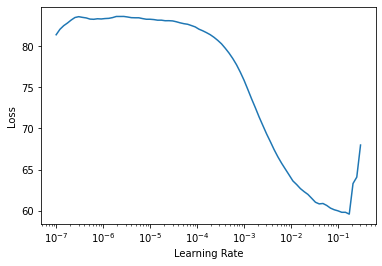

In [ ]:
# head_reg4 = SSD_Head(k, -3.)
# body = create_body(resnet34, pretrained=True)
# mod = Custom_Module(body, head_reg4)
# bb_loss = mae
# lbl_loss = BCE_Loss(len(dls.vocab)) # fxn assigned

# learner = Learner(dls, mod, loss_func = ssd_loss)
# learner.freeze()
# learner.lr_find()
# learner.fit_one_cycle(4,lr=3e-4)

In [ ]:
# learner.save('basic_ssd')
# learner.export('models/20201106_coco_ssd_test_export')

Path('models/20201106_coco_ssd_5e_24l.pth')

## Results for basic SSD

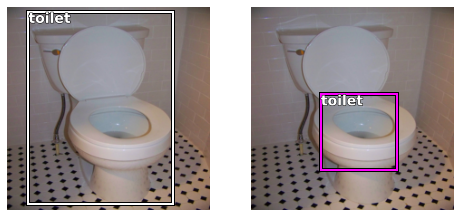

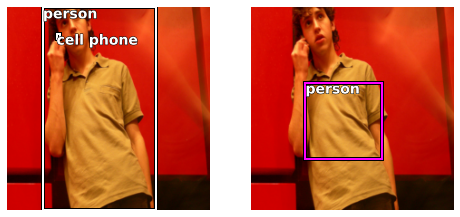

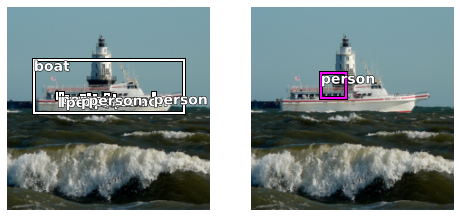

In [ ]:
basic_learner = load_learner('models/20201106_coco_ssd_export_test.pkl')
basic_results = ResultShower(dls, basic_learner, anchors.cpu(), box_size.cpu())
basic_results(3)

# More Boxes!

## New code

- To implement more boxes, we need more anchors, but also more output activations.
- More outputs:
    - Add additional output layers. Currently we have a final 4x4 layer which we use for the grid of 16 anchor boxes. We can add another stride 2 layer to get that down to 2x2, which can give us 4 large anchor boxes. Add another layer with another stride 2 to get a 1x1.
- More anchors:
    - Doing the above will give us another 4 + 1 anchor boxes. 

In [ ]:
# New anchor calculations
def create_anchors(subdivs, zooms, ratios, device='cuda'):
    # create list of permutations per default anchor box
    perms = [(z*r1,z*r2) for z in zooms for (r1,r2) in ratios]
    k = len(perms)
    offsets = [1/(sd*2) for sd in subdivs]
    xs = np.concatenate([np.repeat(np.linspace(o, 1-o, sd), sd)
                         for o,sd in zip(offsets, subdivs)])
    ys = np.concatenate([np.tile  (np.linspace(o, 1-o, sd), sd)
                         for o,sd in zip(offsets, subdivs)])
    ctrs = np.repeat(np.stack([xs,ys], axis=1), k, axis=0)
    hws = np.concatenate([np.array([[o/sd,p/sd] for i in range(sd*sd) for o,p in perms]) 
                          for sd in subdivs])
    box_sizes = tensor(np.concatenate([np.array([1/sd for i in range(sd*sd) for o,p in perms])
                                      for sd in subdivs]), requires_grad=False).unsqueeze(1)
    anchors = tensor(np.concatenate([ctrs, hws], axis=1), requires_grad=False).float()
    return anchors.to(device), box_sizes.to(device)

def create_anchor_boxes(ctr, hw):
    return 2*torch.cat((tensor(ctr-hw/2), tensor(ctr+hw/2)), axis=1)-1

In [ ]:
# New model head
class SSD_MultiHead(Module):
    def __init__(self, k, bias, drop):
        super().__init__()
        self.drop = nn.Dropout(drop)
        self.sconv1 = StdConv(512,256, drop=drop)
        self.sconv2 = StdConv(256,256, drop=drop)
        self.sconv3 = StdConv(256,256, drop=drop)
        self.out1 = OutConv(k, 256, bias)
        self.out2 = OutConv(k, 256, bias)
        self.out3 = OutConv(k, 256, bias)
        
    def forward(self, x):
        x = self.drop(F.relu(x))
        x = self.sconv1(x)
        o1c,o1l = self.out1(x)
        x = self.sconv2(x)
        o2c,o2l = self.out2(x)
        x = self.sconv3(x)
        o3c,o3l = self.out3(x)
        return [torch.cat([o1c,o2c,o3c], dim=1),
                torch.cat([o1l,o2l,o3l], dim=1)]

## Training

In [ ]:
### Init Anchors ###
subdivs = [4, 2, 1]
zooms   = [0.75, 1.0, 1.3]
ratios  = [(1.,1.), (1.,.5), (.5,1)]
k = len(zooms) * len(ratios)
anchors, box_size = create_anchors(subdivs, zooms, ratios)
anchor_boxes = create_anchor_boxes(anchors[:,:2], anchors[:,2:])

In [ ]:
# ### Init Learner ###
# body = create_body(resnet34, pretrained=True)
# head = SSD_MultiHead(k, bias=-4., drop=0.4)
# mod  = Custom_Module(body, head)
# learner = Learner(dls, mod, loss_func=ssd_loss)
# learner.freeze()

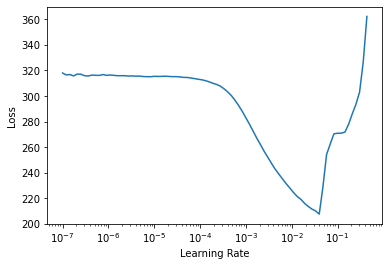

In [ ]:
# lr_min,lr_steep = learner.lr_find()

In [ ]:
# learner.fit_one_cycle(5, lr_max=2e-3)

epoch,train_loss,valid_loss,time
0,72.453468,70.619652,02:18
1,65.138290,126.679092,02:18
2,60.559757,58.304901,02:18
3,55.456501,54.670639,02:19
4,53.027065,53.782372,02:19


In [ ]:
# learner.export('models/20201110_coco_ssd_loss54.pkl')

## Results for more boxes

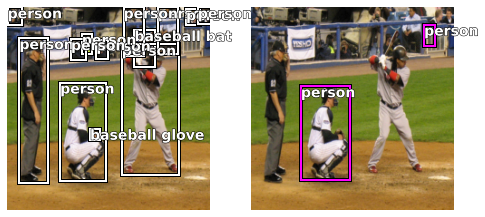

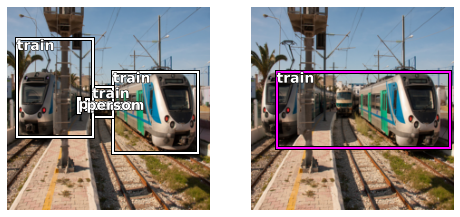

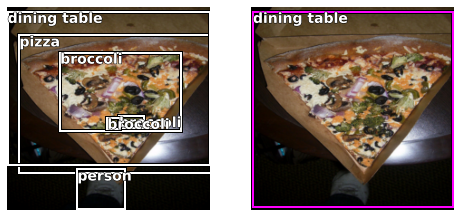

In [ ]:
more_learner = load_learner('models/20201110_coco_ssd_loss54.pkl')
more_results = ResultShower(dls, more_learner, anchors.cpu(), box_size.cpu())
more_results(3)

# Focal Loss

## New code

In [ ]:
class FocalLoss(BCE_Loss):
    def get_weight(self, a, t):
        alpha, gamma = 0.25, 2.0 # vals from paper
        p = a.sigmoid()
        pt = p*t + (1-p)*(1-t)
        w = alpha*t + (1-alpha)*(1-t)
        return w * (1-pt).pow(gamma)

## Training

In [ ]:
### init anchors
subdivs = [4, 2, 1]
zooms   = [0.75, 1.0, 1.3]
ratios  = [(1.,1.), (1.,.5), (.5,1)]
k = len(zooms) * len(ratios)
anchors, box_size = create_anchors(subdivs, zooms, ratios)
anchor_boxes = create_anchor_boxes(anchors[:,:2], anchors[:,2:])

In [ ]:
# ### init loss
# bb_loss  = mae
# lbl_loss = FocalLoss(len(dls.vocab))

# ### init learner
# body = create_body(resnet34, pretrained=True)
# head = SSD_MultiHead(k, -4.)
# mod  = Custom_Module(body, head)
# learner = Learner(dls, mod, loss_func=ssd_loss)
# learner.freeze()
# # lr_min,lr_max = learner.lr_find()

In [ ]:
# learner.fit_one_cycle(3, lr_max=4e-3)

epoch,train_loss,valid_loss,time
0,73.742432,72.669083,02:23
1,65.493736,485.600922,02:24
2,62.515614,60.201359,02:24


In [ ]:
# learner.export('models/20201027_bboxes_C2018_L9-20201110_ssdfocal_loss60.pkl')

## Results for focal loss

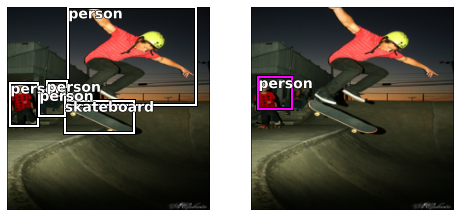

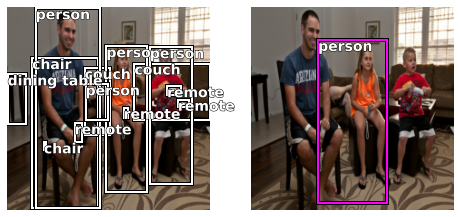

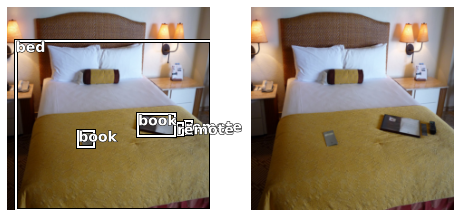

In [ ]:
focal_learner = load_learner('models/20201027_bboxes_C2018_L9-20201110_ssdfocal_loss60.pkl')
focal_results = ResultShower(dls, focal_learner, anchors.cpu(), box_size.cpu())
focal_results(3)